# Tutorial demonstrating verification of v1 precip against jra55

#### Import pyLatte package

In [1]:
from pylatte import utils
from pylatte import skill

#### Currently, the following packages are required to load the data - this process will be replaced by the CAFE cookbook

In [2]:
import numpy as np
import pandas as pd
import xarray as xr

#### Import some plotting packages and widgets

In [3]:
import matplotlib.pyplot as plt
import warnings    
warnings.filterwarnings("ignore")

# Jupyter specific -----
from ipywidgets import FloatProgress
%matplotlib inline

# A note about the methodology of pyLatte
The pyLatte package is constructed around the xarray Python package. This is particularly useful for verification computations which require large numbers of samples (different model runs) to converge. 

The approach here is to generate very large xarray objects that reference all data required for the verification, but do not store the data in memory. Operations are performed on these xarray objects out-of-memory. When it is necessary to perform a compute (e.g. to produce a plot), this is distributed over multiple processors using the dask Python package.

# Initialise dask (currently not working on vm31)

In [4]:
# import dask
# import distributed
# client = distributed.Client(local_dir='/tmp/squ027-dask-worker-space', n_workers=4)
# client

# Construct xarray objects for forecasts and observations
(The CAFE cookbook will replace these code blocks)

In [5]:
# Location of forecast data -----
fcst_folder = '/OSM/CBR/OA_DCFP/data/model_output/CAFE/forecasts/v1/'
fcst_filename = 'atmos_daily*'
fcst_variable = 'precip'

# Location of observation data -----
obsv_folder = '/OSM/CBR/OA_DCFP/data/observations/jra55/isobaric/061_tprat/cat/'
obsv_filename = 'jra.55.tprat.000.1958010100_2016123121.nc'
obsv_variable = 'TPRAT_GDS0_SFC_ave3h'

In [6]:
# Initial dates to include (takes approximately 1 min 30 sec per date) -----
init_dates = pd.date_range('2003-1','2003-3' , freq='1MS')

# Ensembles to include -----
ensembles = range(1,12)

# Forecast length -----
FCST_LENGTH = 2 # years

In [7]:
# Resampling details -----
resample_freq = 'MS'

### Construct forecasts xarray object
Note, dask has a known bug that manifests when trying to concatentate data containing timedelta64 arrays (see https://github.com/pydata/xarray/issues/1952 for further details). For example, try to concatenate the following two Datasets:

`In : path = '/OSM/CBR/OA_DCFP/data/model_output/CAFE/forecasts/v1/yr2002/mn7/'`

`In : ens5 = xr.open_mfdataset(path + 'OUTPUT.5/atmos_daily*.nc', autoclose=True)`

`In : ens6 = xr.open_mfdataset(path + 'OUTPUT.6/atmos_daily*.nc', autoclose=True)`

`In : xr.concat([ens5, ens6],'ensemble')`

`Out : TypeError: invalid type promotion`

The error here is actually caused by the variables `average_DT` and `time_bounds`, which are timedelta64 arrays. However, I still do not fully unstand the bug: concatenation of `ens4` and `ens5`, for example, works fine, even though `ens4` also contains the timedelta64 variables `average_DT` and `time_bounds`. Regardless, because of this bug, it is not possible currently to create an xarray Dataset object containing all model variables. Instead, only the variable of interest (i.e. `fcst_variable` and `obsv_variable`) are retained in the concatenated xarray object.

In [33]:
# Instantiate progress bar -----
f = FloatProgress(min=0, max=len(init_dates)*len(ensembles), description='Loading...') 
display(f)

# Loop over initial dates -----
fcst_list = []
for init_date in init_dates:
    year = init_date.year
    month = init_date.month
    
    # Loop over ensembles -----
    ens_list = []
    for ensemble in ensembles:
        # Signal to increment the progress bar -----
        f.value += 1 
        
        # Stack ensembles into a list -----
        path = fcst_folder + '/yr' + str(year) + '/mn' + str(month) + \
               '/OUTPUT.' + str(ensemble) + '/' + fcst_filename + '.nc'
        dataset = xr.open_mfdataset(path, autoclose=True)[fcst_variable]
        ens_list.append(dataset.resample(time=resample_freq) \
                               .sum(dim='time'))
        
    # Concatenate ensembles -----
    ens_object = xr.concat(ens_list, dim='ensemble')
    ens_object['ensemble'] = ensembles
    
    # Stack concatenated ensembles into a list for each initial date -----                       
    fcst_list.append(utils.datetime_to_leadtime(ens_object))

# Keep track of the lead time for each initialization -----
n_lead_time = [len(x.lead_time) for x in fcst_list]

# Concatenate initial dates -----
da_fcst = xr.concat(fcst_list, dim='init_date')

# Rechunk for chunksizes of at least 1,000,000 elements -----
da_fcst = utils.prune(da_fcst.chunk(chunks={'ensemble' : len(da_fcst.ensemble), 
                                            'lead_time' : len(da_fcst.lead_time)}).squeeze())

FloatProgress(value=0.0, description='Loading...', max=33.0)

#### Truncate the forecast lead times at 2 years
The January and July forecasts are run for 5 years rather than 2 years. The xarray concatenation above can deal with this, but fills the shorter forecasts with nans for lead times longer than 2 years. Let's get rid of some of these nans by truncating the forecasts at the lead time corresponding to the longest 2 year forecast.

In [34]:
max_increments = FCST_LENGTH * 12
n_trunc = max([i for i in n_lead_time if i <= max_increments])
da_fcst = da_fcst.isel(lead_time=range(n_trunc))

### Construct observations xarray object

In [36]:
# Instantiate progress bar -----
f = FloatProgress(min=0, max=1, description='Loading...') 
display(f)

# JRA temperature fields are only save in a time-concatenated form -----
path = obsv_folder + obsv_filename
dataset = xr.open_mfdataset(path, autoclose=True)[obsv_variable]
da_obsv = dataset.rename(fcst_variable) \
                 .rename({'initial_time0_hours' : 'time', 'g0_lon_3' : 'lon', 'g0_lat_2' : 'lat'}) \
                 .resample(time=resample_freq) \
                 .sum(dim='time')

# Stack by initial date to match forecast structure -----
da_obsv = utils.stack_by_init_date(da_obsv,da_fcst.init_date.values,n_trunc)
f.value += 1

# Average over forecast dimension if it is exists -----
if 'forecast_time1' in da_obsv.coords:
    da_obsv = da_obsv.mean(dim='forecast_time1')

# Rechunk for chunksizes of at least 1,000,000 elements -----
da_obsv = utils.prune(da_obsv.chunk(chunks={'init_date' : len(da_obsv.init_date)}).squeeze())

FloatProgress(value=0.0, description='Loading...', max=1.0)

# Let's look at average monthly rainfall over Tasmania

##### Extract forecast and observation over region
Note, we `compute()` the xarray objects here to save time later on. Once dask is working, it will probably be most sensible to leave the objects uncomputed

In [37]:
with utils.timer():
    # Region of interest -----
    region = (-44.0, -40.0, 144.0 , 148.0) # (lat_min,lat_max,lon_min,lon_max)

    unit_conv = 60 * 60 * 24 / 998.2 * 1000
    da_fcst = utils.calc_boxavg_latlon(da_fcst * unit_conv, region).compute()

    da_obsv = utils.calc_boxavg_latlon(da_obsv, region).compute()

##### Load climatology data
Various climatologies are/will be accessable using `utils.load_climatology()`. Here we use a climatology computed over the full 55 year jra reanalysis

In [38]:
jra_clim = utils.load_climatology('jra_1958-2016', 'precip', freq='MS')

da_clim = utils.calc_boxavg_latlon(jra_clim, region).compute()

##### Compute anomaly data
Recall that the forecast and observation data are saved as functions of lead time and initial date. The function `utils.anomalize()` computes anomalies given data and a climatology which each have a datetime dimension `time`. Thus it is necessary to first convert from the lead time/initial date format to a datetime format, then compute the anomaly, the convert back to the lead time/initial date format. The functions `utils.datetime_to_leadtime()` and `utils.leadtime_to_datetime()` enable these types of operations

In [39]:
anomal = lambda data, clim: utils.datetime_to_leadtime(
                                   anomalize(
                                       leadtime_to_datetime(data),clim))

In [40]:
da_fcst_anom = da_fcst.groupby('init_date').apply(anomal, clim=da_clim)

da_obsv_anom = da_obsv.groupby('init_date').apply(anomal, clim=da_clim)

##### Compute persistence data
This requires repeating the data at the first lead time over all lead times. `utils.repeat_data()` allows us to do this

In [41]:
da_pers = utils.repeat_data(da_obsv,'lead_time')

## Before computing any metrics, lets make some example plots

##### Plot the forecast ensembles and observations for the first initial date

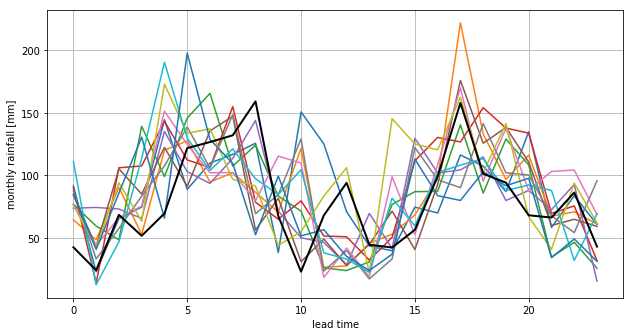

In [42]:
fig1 = plt.figure(figsize=(10,5))

ax = fig1.add_axes([0.1, 0.1, 0.8, 0.8])
ax.grid()
ax.plot(da_fcst['lead_time'],da_fcst.isel(init_date=[0]).squeeze().transpose())
ax.plot(da_obsv['lead_time'],da_obsv.isel(init_date=[0]).squeeze(),'k-',linewidth=2)
ax.set_xlabel('lead time')
ax.set_ylabel('monthly rainfall [mm]');

##### Plot the forecast and observation anomalies for the first initial date

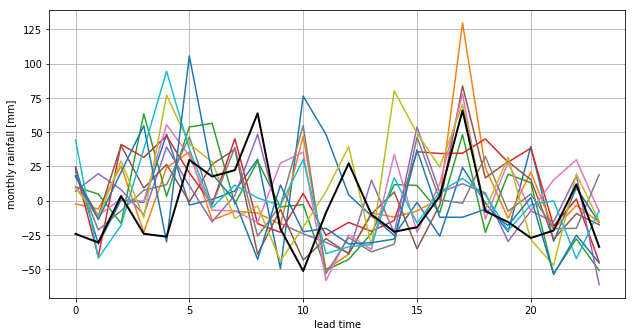

In [45]:
fig1 = plt.figure(figsize=(10,5))

ax = fig1.add_axes([0.1, 0.1, 0.8, 0.8])
ax.grid()
ax.plot(da_fcst['lead_time'],da_fcst_anom.isel(init_date=[0]).squeeze().transpose())
ax.plot(da_obsv['lead_time'],da_obsv_anom.isel(init_date=[0]).squeeze(),'k-',linewidth=2)
ax.set_xlabel('lead time')
ax.set_ylabel('monthly rainfall [mm]');

# Note:
The climatology and persistence data are not actually used here, since this notebook demonstrates skill metrics for probabilistic and event-based forecasts. Currently we only have access to the mean climatology - i.e. we cannot determine climatological probabilities of events occurring. I plan to instead load saved fields of the climatological PDFs which will enable climatological probabilities to be computed for any user-specified event

# Skill metrics for probabilistic forecasts

### E.g. for the event of monthly rainfall over Tasmania being greater than 100 mm/month but less than 600 mm/month

In [46]:
event = '(> 100) and (< 600)'

## Reliability diagram

### Compute reliability as a function of lead time 

In [47]:
with utils.timer():
    # Compute the event data for forecast likelihood and observations -----
    fcst_likelihood = skill.compute_likelihood(skill.did_event(da_fcst, event))
    obsv_logical = skill.did_event(da_obsv, event)

    # Compute the reliability -----
    fcst_probabilities = np.linspace(0,1,len(da_fcst['ensemble'])+1)
    reliability = skill.compute_reliability(fcst_likelihood,obsv_logical,
                                            fcst_probabilities,indep_dims='init_date')

   Elapsed: 0.10023713111877441 sec


   Elapsed: 1.5796394348144531 sec


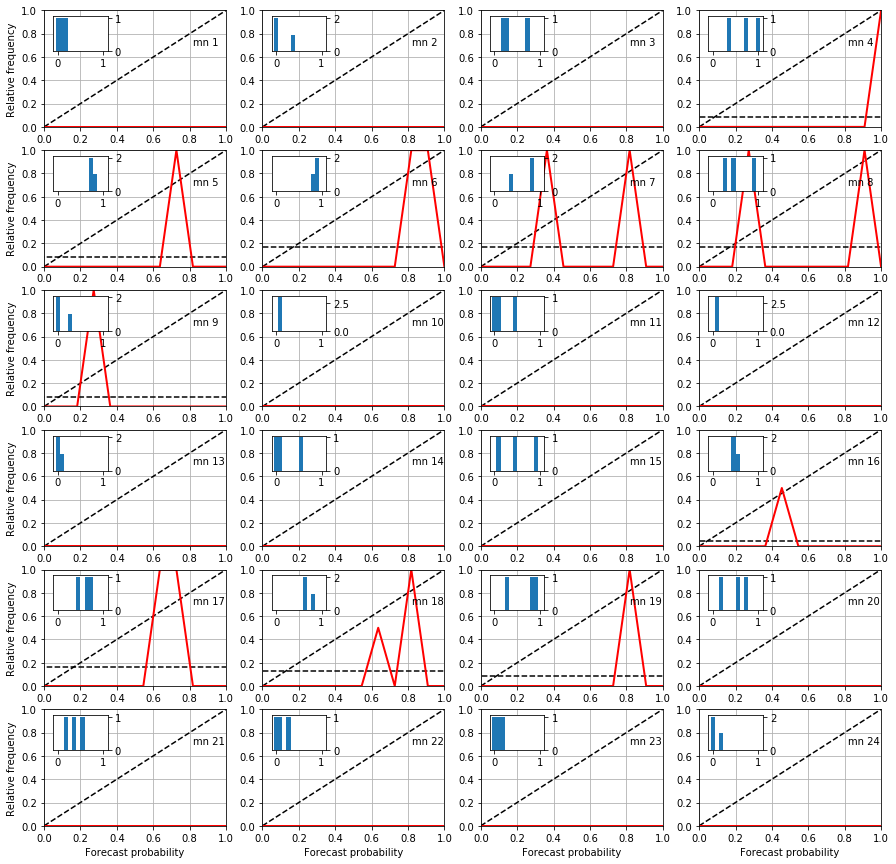

In [49]:
with utils.timer():
    ncol = 4; nrow = int(np.ceil(len(da_fcst.lead_time)/ncol));
    fig, axs = plt.subplots(figsize=(15,15), nrows=nrow, ncols=ncol);

    for idx,ax in enumerate(axs.reshape(-1)): 
        ax.grid()
        ax.plot([0, 1],[0, 1],'k--')
        sample_clim = reliability['relative_freq'].isel(lead_time=idx, drop=True).mean()
        ax.plot([-1, 2],[sample_clim, sample_clim],'k--')
        ax.plot(reliability['forecast_probability'],
                reliability['relative_freq'].isel(lead_time=idx, drop=True),'r',linewidth=2)
        ax.set_xlim(0,1)
        ax.set_ylim(0,1)
        ax.text(0.82,0.7,'mn '+str(idx+1))

        if idx % ncol == 0:
            ax.set_ylabel('Relative frequency')

        if idx / ncol >= nrow - 1:
            ax.set_xlabel('Forecast probability')

        fig = plt.gcf()
        box = ax.get_position()
        width = box.width
        height = box.height
        subpos = [0.05,0.65,0.3,0.3]
        inax_position  = ax.transAxes.transform(subpos[0:2])
        transFigure = fig.transFigure.inverted()
        infig_position = transFigure.transform(inax_position)    
        x = infig_position[0]
        y = infig_position[1]
        width *= subpos[2]
        height *= subpos[3] 
        subax = fig.add_axes([x,y,width,height])
        subax.yaxis.tick_right()
        subax.bar(reliability['forecast_probability'],reliability['fcst_number'].isel(lead_time=idx, drop=True),
                  width=reliability['forecast_probability'][1])

### Compute reliability across all lead times

In [50]:
with utils.timer():
    # Compute the event data for forecast likelihood and observations -----
    fcst_likelihood = skill.compute_likelihood(skill.did_event(da_fcst, event))
    obsv_logical = skill.did_event(da_obsv, event)

    # Compute the reliability -----
    fcst_probabilities = np.linspace(0,1,len(da_fcst['ensemble'])+1)
    reliability = skill.compute_reliability(fcst_likelihood,obsv_logical,fcst_probabilities,
                                            indep_dims=['init_date','lead_time'])

   Elapsed: 0.08475518226623535 sec


   Elapsed: 0.06371426582336426 sec


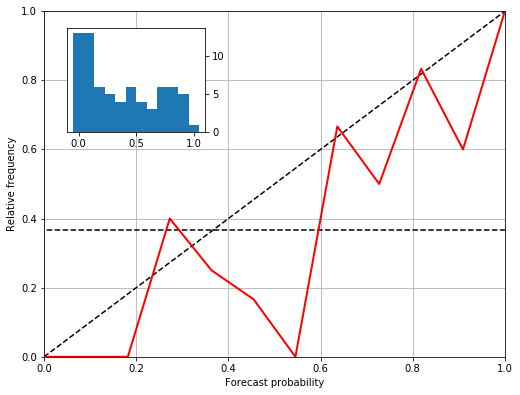

In [51]:
with utils.timer():
    fig1 = plt.figure(figsize=(8,6))

    ax = fig1.add_axes([0.1, 0.1, 0.8, 0.8])
    ax.grid()
    ax.plot([0, 1],[0, 1],'k--')
    sample_clim = reliability['relative_freq'].mean()
    ax.plot([-1, 2],[sample_clim, sample_clim],'k--')
    ax.plot(reliability['forecast_probability'],reliability['relative_freq'],'r',linewidth=2)
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    ax.set_xlabel('Forecast probability')
    ax.set_ylabel('Relative frequency');

    fig = plt.gcf()
    box = ax.get_position()
    width = box.width
    height = box.height
    subpos = [0.05,0.65,0.3,0.3]
    inax_position  = ax.transAxes.transform(subpos[0:2])
    transFigure = fig.transFigure.inverted()
    infig_position = transFigure.transform(inax_position)    
    x = infig_position[0]
    y = infig_position[1]
    width *= subpos[2]
    height *= subpos[3] 
    subax = fig.add_axes([x,y,width,height])
    subax.yaxis.tick_right()
    subax.bar(reliability['forecast_probability'],reliability['fcst_number'],
              width=reliability['forecast_probability'][1]);

## Brier score

### Compute Brier scores as a function of lead time

In [52]:
with utils.timer():
    # Compute the event data for forecast likelihood and observations -----
    fcst_likelihood = skill.compute_likelihood(skill.did_event(da_fcst, event))
    obsv_logical = skill.did_event(da_obsv, event)

    # Compute the Brier score -----
    fcst_probabilities = np.linspace(0,1,len(da_fcst['ensemble'])-6)
    Brier = skill.compute_Brier_score(fcst_likelihood,obsv_logical,fcst_prob=fcst_probabilities,
                                      indep_dims='init_date')

   Elapsed: 0.10012173652648926 sec


   Elapsed: 0.037175655364990234 sec


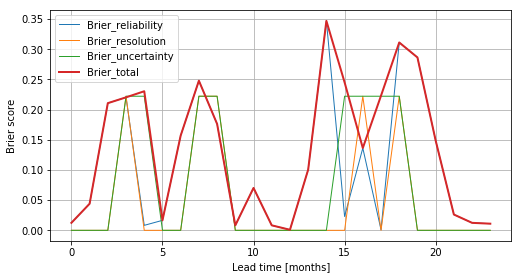

In [53]:
with utils.timer():
    fig1 = plt.figure(figsize=(8,4))

    ax = fig1.add_axes([0.1, 0.1, 0.8, 0.8])
    ax.grid()
    ax.plot(Brier['lead_time'],Brier['Brier_reliability'],linewidth=1)
    ax.plot(Brier['lead_time'],Brier['Brier_resolution'],linewidth=1)
    ax.plot(Brier['lead_time'],Brier['Brier_uncertainty'],linewidth=1)
    ax.plot(Brier['lead_time'],Brier['Brier_total'],linewidth=2)
    ax.set_xlabel('Lead time [months]')
    ax.set_ylabel('Brier score')
    ax.legend();

## Relative operating characteristic

### Compute ROC diagrams as a function of lead time

In [54]:
with utils.timer():
    # Compute the event data for forecast likelihood and observations -----
    fcst_likelihood = skill.compute_likelihood(skill.did_event(da_fcst, event))
    obsv_logical = skill.did_event(da_obsv, event)

    # Compute the roc -----
    fcst_probabilities = np.linspace(0,1,len(da_fcst['ensemble'])+1)
    roc = skill.compute_roc(fcst_likelihood, obsv_logical, fcst_probabilities, 
                            indep_dims='init_date')

   Elapsed: 0.333418607711792 sec


   Elapsed: 0.5534265041351318 sec


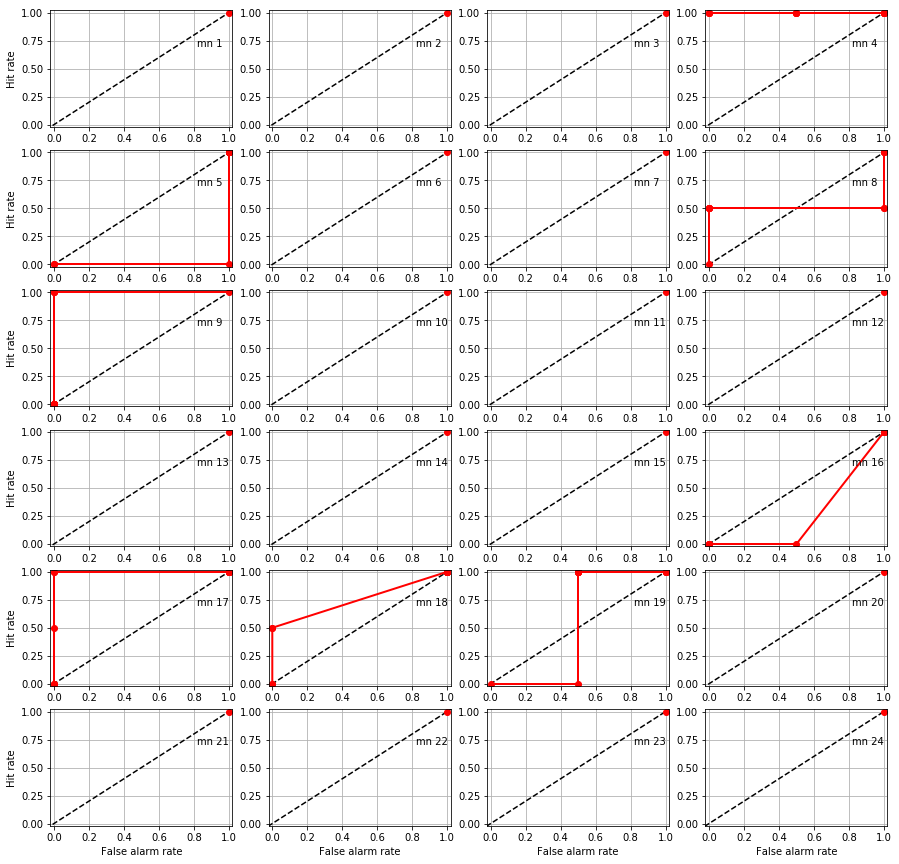

In [56]:
with utils.timer():
    ncol = 4; nrow = int(np.ceil(len(da_fcst.lead_time)/ncol));
    fig, axs = plt.subplots(figsize=(15,15), nrows=nrow, ncols=ncol);

    for idx,ax in enumerate(axs.reshape(-1)): 
        ax.grid()
        ax.plot([-1, 2],[-1, 2],'k--')
        ax.plot(roc['false_alarm_rate'].isel(lead_time=idx, drop=True),
                roc['hit_rate'].isel(lead_time=idx, drop=True),'ro-',linewidth=2)
        ax.set_xlim(-0.02,1.02)
        ax.set_ylim(-0.02,1.02)
        ax.text(0.82,0.7,'mn '+str(idx+1))

        if idx % ncol == 0:
            ax.set_ylabel('Hit rate')

        if idx / ncol >= nrow - 1:
            ax.set_xlabel('False alarm rate')

### Compute ROC diagram for all lead times

In [57]:
with utils.timer():
    # Compute the event data for forecast likelihood and observations -----
    fcst_likelihood = skill.compute_likelihood(skill.did_event(da_fcst, event))
    obsv_logical = skill.did_event(da_obsv, event)

    # Compute the roc -----
    fcst_probabilities = np.linspace(0,1,len(da_fcst['ensemble'])+1)
    roc = skill.compute_roc(fcst_likelihood, obsv_logical, fcst_probabilities, 
                            indep_dims=('init_date','lead_time'))

   Elapsed: 0.2761693000793457 sec


   Elapsed: 0.024956226348876953 sec


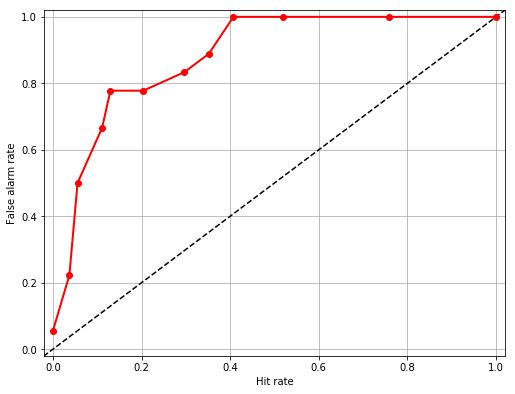

In [58]:
with utils.timer():
    fig1 = plt.figure(figsize=(8,6))

    ax = fig1.add_axes([0.1, 0.1, 0.8, 0.8])
    ax.grid()
    ax.plot([-1, 2],[-1, 2],'k--')
    ax.plot(roc['false_alarm_rate'],roc['hit_rate'],'ro-',linewidth=2)
    ax.set_xlim(-0.02,1.02)
    ax.set_ylim(-0.02,1.02)
    ax.set_xlabel('Hit rate')
    ax.set_ylabel('False alarm rate');

## Discrimination diagram

### Compute discrimination diagrams as a function of lead time

In [59]:
with utils.timer():
    # Compute the event data for forecast likelihood and observations -----
    fcst_likelihood = skill.compute_likelihood(skill.did_event(da_fcst, event))
    obsv_logical = skill.did_event(da_obsv, event)

    # Compute the discrimination -----
    fcst_probabilities = np.linspace(0,1,len(da_fcst['ensemble'])+1)
    discrimination = skill.compute_discrimination(fcst_likelihood, obsv_logical, 
                                                   fcst_probabilities, indep_dims='init_date')

   Elapsed: 0.1356201171875 sec


   Elapsed: 1.4524650573730469 sec


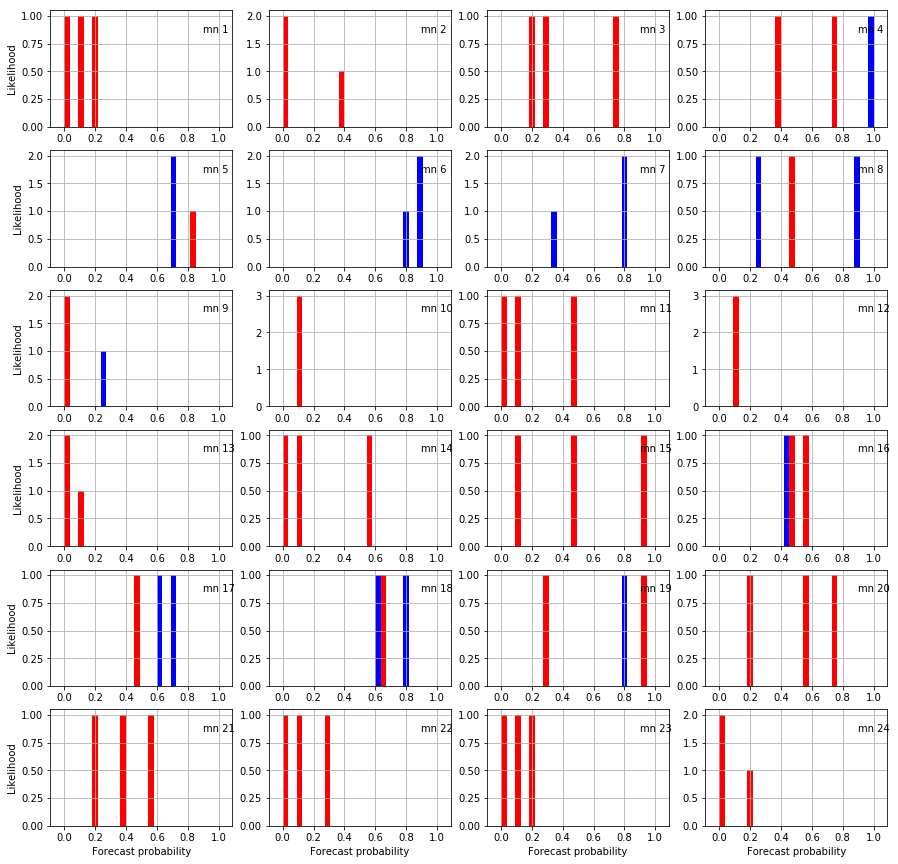

In [61]:
with utils.timer():
    ncol = 4; nrow = int(np.ceil(len(da_fcst.lead_time)/ncol));
    fig, axs = plt.subplots(figsize=(15,15), nrows=nrow, ncols=ncol);

    for idx,ax in enumerate(axs.reshape(-1)): 
        ax.grid()
        scale_width = 2.5
        ax.bar(discrimination.bins-discrimination.bins[1]/scale_width/2,
            discrimination['hist_obsved'].isel(lead_time=idx, drop=True),
            width=discrimination.bins[1]/scale_width,
            color='b')
        ax.bar(discrimination.bins+discrimination.bins[1]/scale_width/2,
                discrimination['hist_not_obsved'].isel(lead_time=idx, drop=True),
                width=discrimination.bins[1]/scale_width,
                color='r')
        max_count = max([discrimination['hist_obsved'].isel(lead_time=idx, drop=True).max(), 
                         discrimination['hist_not_obsved'].isel(lead_time=idx, drop=True).max()])
        ax.text(0.9,0.85*max_count,'mn '+str(idx+1))

        if idx % ncol == 0:
            ax.set_ylabel('Likelihood')

        if idx / ncol >= nrow - 1:
            ax.set_xlabel('Forecast probability')

### Compute discrimination diagram for all lead times

In [62]:
with utils.timer():
    discrimination = skill.compute_discrimination(fcst_likelihood, obsv_logical, 
                                                  fcst_probabilities, indep_dims=('init_date','lead_time'))

   Elapsed: 0.009061098098754883 sec


   Elapsed: 0.05414700508117676 sec


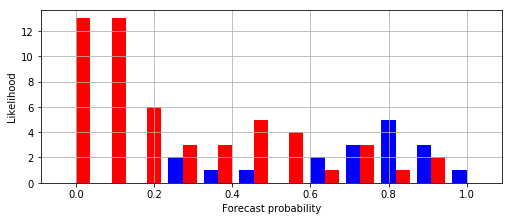

In [63]:
with utils.timer():
    fig1 = plt.figure(figsize=(8,3))

    ax1 = fig1.add_axes([0.1, 0.1, 0.8, 0.8])
    ax1.grid()
    scale_width = 2.5
    ax1.bar(discrimination.bins-discrimination.bins[1]/scale_width/2,
            discrimination['hist_obsved'],
            width=discrimination.bins[1]/scale_width,
            color='b')
    ax1.bar(discrimination.bins+discrimination.bins[1]/scale_width/2,
            discrimination['hist_not_obsved'],
            width=discrimination.bins[1]/scale_width,
            color='r')
    ax1.set_xlabel('Forecast probability')
    ax1.set_ylabel('Likelihood');

# Skill metrics for categorized forecasts

## Contingency table

### E.g. for 4 categories between 25 and 150 mm of monthly rainfall

In [64]:
category_edges = np.linspace(25,150,5)

### Compute contingency as a function of lead time

In [65]:
with utils.timer():
    contingency = skill.compute_contingency_table(da_fcst,da_obsv, category_edges,
                                                  ensemble_dim='ensemble', indep_dims='init_date')

   Elapsed: 0.8553731441497803 sec


   Elapsed: 0.7328665256500244 sec


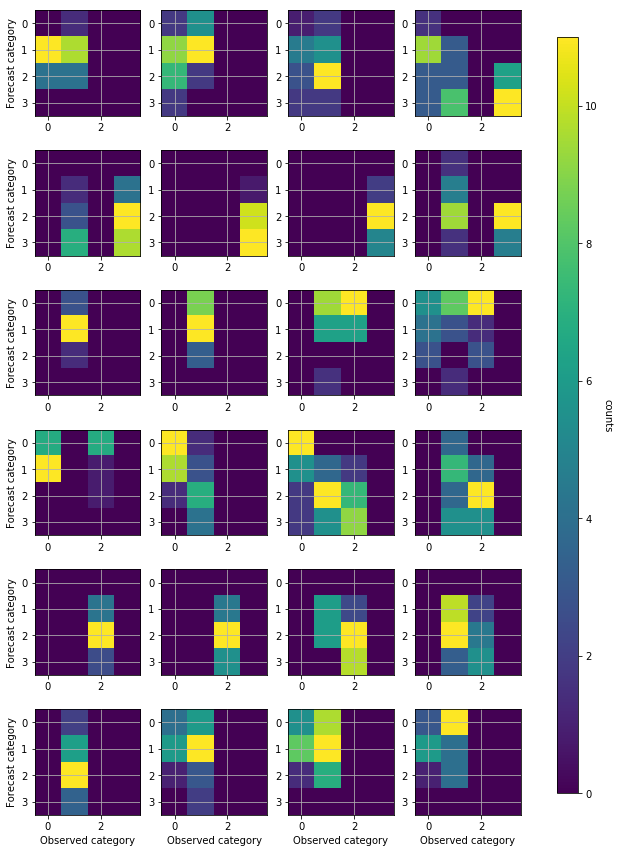

In [67]:
with utils.timer():
    ncol = 4; nrow = int(np.ceil(len(da_fcst.lead_time)/ncol));
    fig, axs = plt.subplots(figsize=(10,15), nrows=nrow, ncols=ncol);

    for idx,ax in enumerate(axs.reshape(-1)): 
        ax.grid()
        im = ax.imshow(contingency.isel(lead_time=idx, drop=True))
        # ax.text(0.82,0.7,'mn '+str(idx+1))

        if idx % ncol == 0:
            ax.set_ylabel('Forecast category')

        if idx / ncol >= nrow - 1:
            ax.set_xlabel('Observed category')

    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.03, 0.7])
    fig.colorbar(im, cax=cbar_ax);
    cbar_ax.set_ylabel('counts', rotation=270, labelpad=15);

## Accuracy score

In [68]:
with utils.timer():
    accuracy_score = skill.compute_accuracy_score(contingency)

   Elapsed: 0.008023738861083984 sec


## Heidke skill score

In [69]:
with utils.timer():
    Heidke_score = skill.compute_Heidke_score(contingency)

   Elapsed: 0.008778095245361328 sec


## Peirce skill score / Hanssen and Kuipers discriminant

In [70]:
with utils.timer():
    Peirce_score = skill.compute_Peirce_score(contingency)

   Elapsed: 0.010062456130981445 sec


## Gerrity score

In [71]:
with utils.timer():
    Gerrity_score = skill.compute_Gerrity_score(contingency)

   Elapsed: 0.10654091835021973 sec


#### Plot as a function of lead_time

   Elapsed: 0.03762483596801758 sec


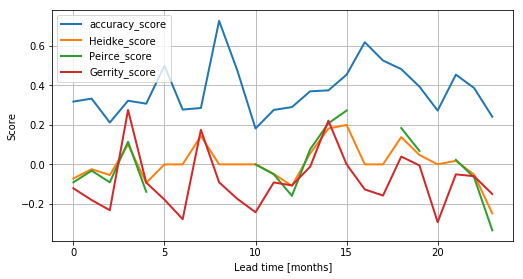

In [72]:
with utils.timer():
    fig1 = plt.figure(figsize=(8,4))

    ax = fig1.add_axes([0.1, 0.1, 0.8, 0.8])
    ax.grid()
    ax.plot(accuracy_score['lead_time'],accuracy_score,linewidth=2)
    ax.plot(Heidke_score['lead_time'],Heidke_score,linewidth=2)
    ax.plot(Peirce_score['lead_time'],Peirce_score,linewidth=2)
    ax.plot(Gerrity_score['lead_time'],Gerrity_score,linewidth=2)
    ax.set_xlabel('Lead time [months]')
    ax.set_ylabel('Score');
    ax.legend();

# Skill metrics for dichotomously categorized forecasts

## Contingency table

### E.g. for monthly rainfall being > or < 100 mm 

In [ ]:
category_edges = [-np.inf, 100, np.inf]

### Compute dichotomous contingency as a function of lead time

In [84]:
with utils.timer():
    contingency = skill.compute_contingency_table(da_fcst,da_obsv,category_edges,
                                                  ensemble_dim='ensemble',indep_dims='init_date')

   Elapsed: 0.2115800380706787 sec


## Bias score

In [74]:
with utils.timer():
    bias_score = skill.compute_bias_score(contingency)

   Elapsed: 0.005953073501586914 sec


## Probability of detection

In [75]:
with utils.timer():
    hit_rate = skill.compute_hit_rate(contingency)

   Elapsed: 0.003431558609008789 sec


## False alarm ratio

In [76]:
with utils.timer():
    false_alarm_ratio = skill.compute_false_alarm_ratio(contingency)

   Elapsed: 0.004576444625854492 sec


## False alarm rate

In [77]:
with utils.timer():
    false_alarm_rate = skill.compute_false_alarm_rate(contingency)

   Elapsed: 0.005016326904296875 sec


## Success ratio

In [78]:
with utils.timer():
    success_ratio = skill.compute_success_ratio(contingency)

   Elapsed: 0.003170013427734375 sec


## Threat score

In [79]:
with utils.timer():
    threat_score = skill.compute_threat_score(contingency)

   Elapsed: 0.004595756530761719 sec


## Equitable threat score

In [80]:
with utils.timer():
    equit_threat_score = skill.compute_equit_threat_score(contingency)

   Elapsed: 0.008847713470458984 sec


## Odds ratio

In [81]:
with utils.timer():
    odds_ratio = skill.compute_odds_ratio(contingency)

   Elapsed: 0.005493879318237305 sec


## Odds ratio skill score

In [82]:
with utils.timer():
    odds_ratio_skill = skill.compute_odds_ratio_skill(contingency)

   Elapsed: 0.009001731872558594 sec


### Plot as a function of lead time

   Elapsed: 0.05028963088989258 sec


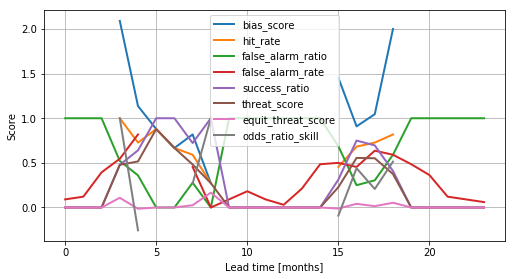

In [83]:
with utils.timer():
    fig1 = plt.figure(figsize=(8,4))

    ax = fig1.add_axes([0.1, 0.1, 0.8, 0.8])
    ax.grid()
    ax.plot(bias_score['lead_time'],bias_score,linewidth=2)
    ax.plot(hit_rate['lead_time'],hit_rate,linewidth=2)
    ax.plot(false_alarm_ratio['lead_time'],false_alarm_ratio,linewidth=2)
    ax.plot(false_alarm_rate['lead_time'],false_alarm_rate,linewidth=2)
    ax.plot(success_ratio['lead_time'],success_ratio,linewidth=2)
    ax.plot(threat_score['lead_time'],threat_score,linewidth=2)
    ax.plot(equit_threat_score['lead_time'],equit_threat_score,linewidth=2)
    # ax.plot(odds_ratio['lead_time'],odds_ratio,linewidth=2)
    ax.plot(odds_ratio_skill['lead_time'],odds_ratio_skill,linewidth=2)
    ax.set_xlabel('Lead time [months]')
    ax.set_ylabel('Score');
    ax.legend();

# Close dask client

In [ ]:
# with utils.timer():
#     client.close()